In [57]:
# imports
from fastai.tabular.all import *
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns

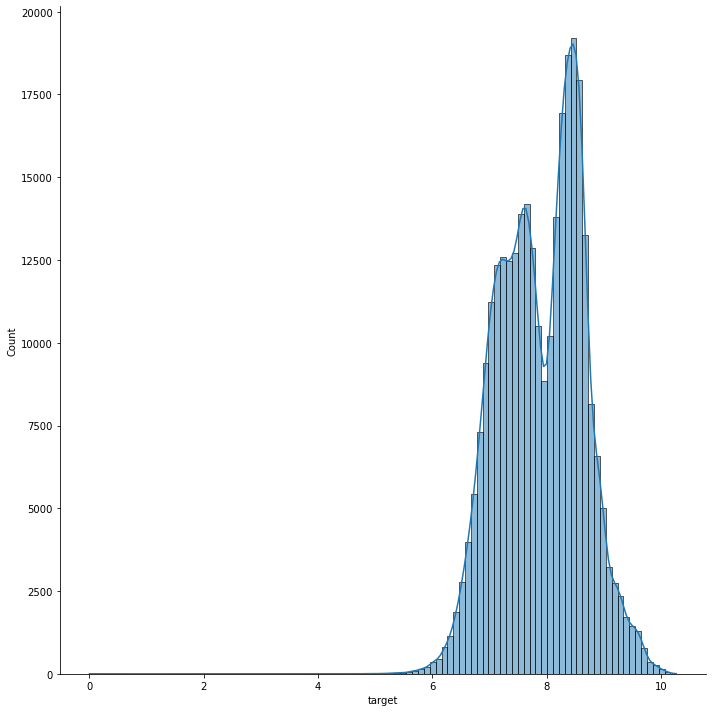

In [33]:
# read and split into train and valid data
data = pd.read_csv("../inputs/train_folds.csv")
train = data[data.kfold !=0]
valid = data[data.kfold ==0]
# distribution for target in order to populate y_range
sns.displot(data, x="target", bins=100, kde=True, height = 10)

In [56]:
# # read w/o split into train and valid data
# train = pd.read_csv("../inputs/train_folds.csv")
# # distribution for target in order to populate y_range
# sns.displot(train, x="target", bins=100, kde=True, height = 10)

In [34]:
# get data splits
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [35]:
# keep relevant fields
train = train.drop(["kfold","id"], axis=1)
valid = valid.drop(["kfold","id"], axis=1)

In [36]:
# get cat and cont fields
cat_features = train.select_dtypes(exclude = 'number').columns.tolist()
cont_features = train.select_dtypes(include = 'number').columns.tolist()
cont_features.remove('target')

In [37]:
# tabular pandas
to = TabularPandas(train, procs=[Categorify, FillMissing, Normalize], # this object normalizes the test data as well during inference
                   cat_names = cat_features,
                   cont_names = cont_features,
                   y_names='target',
                   splits=splits)

In [38]:
# example training data
to.xs.iloc[:2]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
190106,-0.719838,1.045111,-1.634661,1.299291,-0.996912,-0.307057,-0.790693,2.140863,-1.079955,-1.139714,-0.759846,-0.668781,0.046022,-0.443683
181364,-0.418117,1.040415,-0.825909,-0.119900,0.113739,-0.289127,0.212393,-0.123970,-1.185577,-0.415900,-0.025617,-0.008218,0.715545,-0.963649


In [49]:
# create dataloaders
dls = to.dataloaders(bs=256)
dls.show_batch()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,0.267602,0.783686,0.236854,0.431125,0.283280,0.642510,0.541761,0.723521,0.419917,0.367264,0.475572,0.437587,0.797919,0.305948,8.586109
1,0.505578,0.740236,0.709260,0.486643,0.282628,0.634610,0.594315,0.960481,0.376598,0.524747,0.687710,0.716913,0.643936,0.808598,8.480749
2,0.496749,0.619967,0.741379,0.325540,0.281873,0.716566,0.784653,0.328483,0.414901,0.794821,0.645168,0.701330,0.738250,0.356815,7.446364
3,0.560692,0.553570,0.257749,0.873250,0.580487,0.487837,0.478786,0.271785,0.438149,0.608827,0.429639,0.479918,0.345684,0.502971,8.327167
4,0.257167,0.556078,0.533353,0.830993,0.614990,0.230468,0.260265,0.532461,0.288839,0.268436,0.193262,0.345371,0.343814,0.186615,8.143358
5,0.281442,0.684609,0.725429,0.207904,0.317062,0.260351,0.261196,0.307813,0.327403,0.333888,0.197688,0.290545,0.392855,0.362990,6.594886
6,0.727046,0.059923,0.185479,0.606958,0.535304,0.250150,0.320348,0.419079,0.907324,0.393634,0.310406,0.276633,0.339589,0.646023,7.740259
7,0.478668,0.736242,0.738540,0.240839,0.285323,0.509686,0.694835,0.367986,0.442858,0.567498,0.542642,0.714453,0.350701,0.584912,7.105055
8,0.321331,0.798700,0.746581,0.902313,0.698113,0.266151,0.327226,0.452710,0.292880,0.570481,0.282716,0.455936,0.383256,0.242000,8.625762
9,0.510340,0.681520,0.635358,0.754148,0.429291,0.694111,0.667371,0.897120,0.427137,0.806611,0.629739,0.771251,0.591286,0.556825,8.440458


In [50]:
# create learn object
learn = tabular_learner(dls, layers = [112, 56, 28], y_range = [0,15], metrics=rmse)

In [53]:
# train
#learn.fit_one_cycle(5)
learn.fit(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.513145,0.514009,0.716944,00:08
1,0.504792,0.511314,0.715063,00:08
2,0.509504,0.513302,0.716451,00:08
3,0.505918,0.509282,0.713640,00:08
4,0.503567,0.512443,0.715851,00:08


In [54]:
# See model structure
# learn.model

In [55]:
# predict on valid data and print rmse
dl = learn.dls.test_dl(valid)
valid_len = valid.shape[0]
pred = learn.get_preds(dl=dl)[0].numpy().reshape(valid_len,)
actuals = valid.target.to_numpy()
mean_squared_error(actuals,pred,squared=False)

0.7185798292119652

In [116]:
# predict on test data
test = pd.read_csv("../inputs/test.csv")
ss = test.copy()
ss = ss[['id']]
test.drop(['id'], axis=1, inplace=True)
test['target'] = 0 # dummy
test_len = test.shape[0]
dl = learn.dls.test_dl(test)
pred = learn.get_preds(dl=dl)[0].numpy().reshape(test_len,)
ss.loc[:,'target'] = pd.Series(pred)